<a href="https://colab.research.google.com/github/lail-lei/BIM-GPT2/blob/main/evaluation/5_cluster_Evaluation_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [ ]:
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import os, sys, email,re
import re

## Data Import and Cleaning

In [ ]:
human_recipes = pd.read_csv('formatted_all.csv')

In [ ]:
# clean recipes for kmeans
# remove input labels, control tokens leading spaces, and transform to lower case
human_recipes = human_recipes.recipes.str.replace("<INPUT_START>.*<INPUT_END>", "").str.replace("<.*?>", "").str.lower().str.strip()

In [ ]:
human_recipes

0       24-26 cupcakes      1/2 cup vegetable oil   2 ...
1       one 9-inch pie     1 store bought pie crust   ...
2       8 to 10 servings     1/2 cup salted butter pre...
3       serves 8-10     1/2 cup unsalted butter melted...
4       16     150g allinson s plain white flour  50g ...
                              ...                        
4447    one (10-inch) cake     1 tablespoon butter   2...
4448    about 3 dozen cookies     10 ounces unsalted b...
4449    12 cupcakes     12 pre made cupcakes baked fro...
4450    2 layers     3/4 cup butter flavored vegetable...
4451    about 2 dozen 3-inch cookies     1 cup unsalte...
Name: recipes, Length: 4452, dtype: object

In [ ]:
generated = pd.read_csv('generated.csv')

In [ ]:
# clean recipes for kmeans
# remove input labels, control tokens leading spaces, and transform to lower case
generated = generated.recipes.str.replace("<INPUT_START>.*<INPUT_END>", "").str.replace("<.*?>", "").str.lower().str.strip()

In [ ]:
generated

0      12 cupcakes     12 tablespoons unsalted butter...
1      12 cupcakes     1/2 cup unsalted butter soften...
2      24 cupcakes     1 1/2 sticks unsalted butter a...
3      24 cupcakes     1/2 cup vegetable oil   1 cup ...
4      12-15 cupcakes     3/4 cup unsalted butter roo...
                             ...                        
275    24 cupcakes     1 1/2 sticks unsalted butter m...
276    12     1 cup salted butter   1 cup all purpose...
277    12     115g butter   4 egg  115g self raising ...
278    24 cupcakes     1 cup unsalted butter softened...
279    12-14 cupcakes     3/4 cup unsalted butter roo...
Name: recipes, Length: 280, dtype: object

## TF-IDF Vectorization

In [ ]:
# let's concat to make tf-idf work better across all documents
concat = pd.concat([human_recipes, generated])

In [ ]:
concat

0      24-26 cupcakes      1/2 cup vegetable oil   2 ...
1      one 9-inch pie     1 store bought pie crust   ...
2      8 to 10 servings     1/2 cup salted butter pre...
3      serves 8-10     1/2 cup unsalted butter melted...
4      16     150g allinson s plain white flour  50g ...
                             ...                        
275    24 cupcakes     1 1/2 sticks unsalted butter m...
276    12     1 cup salted butter   1 cup all purpose...
277    12     115g butter   4 egg  115g self raising ...
278    24 cupcakes     1 cup unsalted butter softened...
279    12-14 cupcakes     3/4 cup unsalted butter roo...
Name: recipes, Length: 4732, dtype: object

In [ ]:
# use TFIDF for recipe vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(concat)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [ ]:
tf_idf_human = tf_idf_array[:4452]
tf_idf_bim = tf_idf_array[-280:]

In [ ]:
len(tf_idf_human)

4452

In [ ]:
len(tf_idf_bim)

280

## KMeans 

### Finding Number of Clusters

**Elbow Plot**

In [ ]:
# let's create inertias as a function of k on human recipes
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(tf_idf_human)
                for k in range(1, 11)] #consider all k sizes from 1 to 5
# hold in an array
inertias = [model.inertia_ for model in kmeans_per_k]

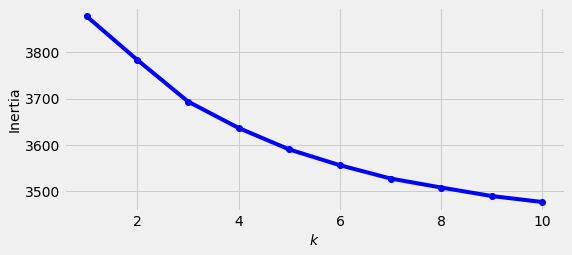

In [ ]:

# let's plot our inertias per k value
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
# annotation to point out elbow 
plt.show()

**Silhouette Scores**

In [ ]:
# run kmeans to get the clusters for our silhoutte scores
from sklearn.cluster import KMeans
# start with 10
kmeans10 = KMeans(n_clusters=10, random_state=42)
# train the model
y_pred = kmeans10.fit_predict(tf_idf_human)

In [ ]:
# let's create the silhouette inertia values
from sklearn.metrics import silhouette_score
silhouette_score(tf_idf_human, kmeans10.labels_)
# hold in an array
silhouette_scores = [silhouette_score(tf_idf_human, model.labels_)
                     for model in kmeans_per_k[1:]]

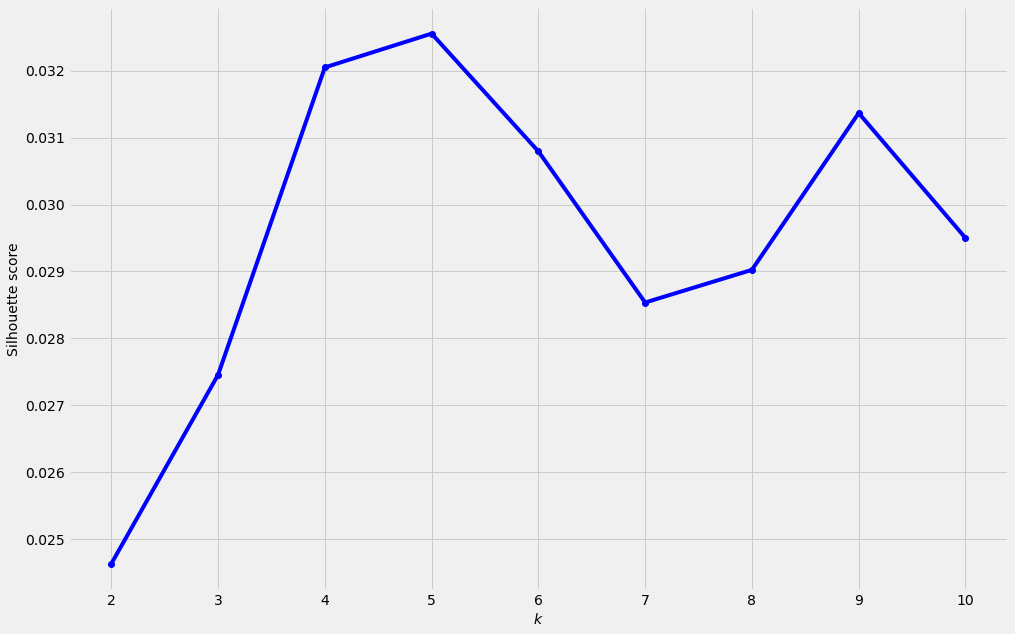

In [ ]:
# plot the sillhoute inertias 
plt.figure(figsize=(15, 10))
plt.plot(range(2, 11), silhouette_scores, "bo-") # cluster size k = 1 is cut so start at 2
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.gca().set_xticks(range(2, 11))
plt.show()

### Training K-means on human writtten recipes

In [ ]:
# let's use SKlearn KMeans to cluster our data
from sklearn.cluster import KMeans
# we're using principle component analysis to reduce 
# dimensionality to 2 most important features
sklearn_pca = PCA(n_components = 2)
Y_sklearn_human = sklearn_pca.fit_transform(tf_idf_human)
# now let's group into 5 clusters
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
# train kmeans on our PCA-processed data
fitted = kmeans.fit(Y_sklearn_human)
# and predict our clusters
prediction_human = kmeans.predict(Y_sklearn_human)

In [ ]:
# these are the centroids for our four clusters
centroids  = kmeans.cluster_centers_ 
centroids

array([[-0.0260527 , -0.1306846 ],
       [-0.04031789,  0.27120789],
       [ 0.14987524, -0.06132723],
       [ 0.31459089,  0.04146897],
       [-0.19061548, -0.05620607]])

In [ ]:
# and these are the centroids for each recipe
centroid_labels = [centroids[i] for i in prediction_human]

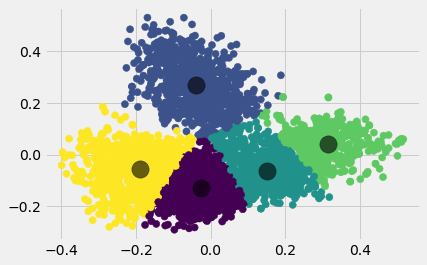

In [ ]:
plt.scatter(Y_sklearn_human[:, 0], Y_sklearn_human[:, 1], c=prediction_human, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],c='black', s=300, alpha=0.6);

In [ ]:
# let's check to see what features (words)
# are most common in each cluster 
# thanks to https://towardsdatascience.com/k-means-clustering-8e1e64c1561c
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

In [ ]:
# dominant features per cluster
dfs_human = get_top_features_cluster(tf_idf_array, prediction_human, 15)

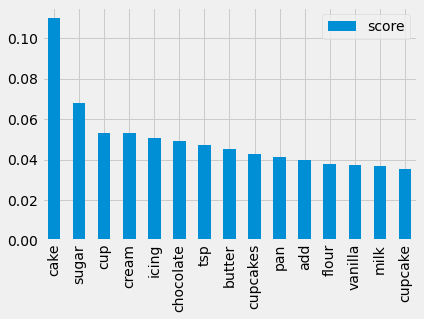

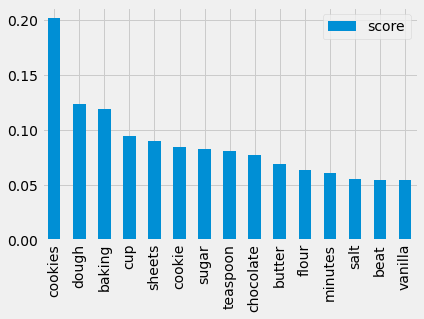

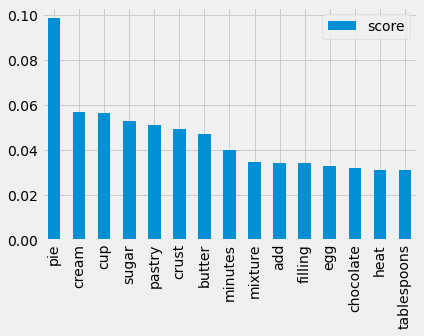

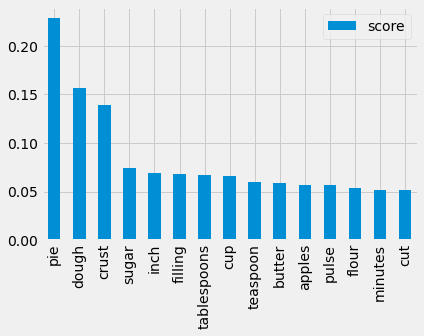

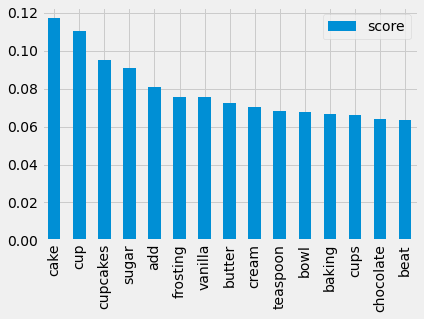

In [ ]:
for item in dfs_human:
  plot = item.plot(kind="bar", xticks=item.index, rot=90)
  plot.set_xticklabels(item.features)

In [ ]:
human_clustered = pd.DataFrame(tf_idf_human)
human_clustered['kmean'] = kmeans.labels_
human_clustered['kmean'].value_counts()

0    1122
4    1101
1     896
2     872
3     461
Name: kmean, dtype: int64

###Testing on generated recipes

In [ ]:
# now let's perform pca to reduce generated recipe dimensionality
Y_sklearn_bim = sklearn_pca.fit_transform(tf_idf_bim)

In [ ]:
# and predict our clusters
prediction_bim = kmeans.predict(Y_sklearn_bim)

In [ ]:
# and these are the centroids for each recipe
centroid_gen_labels = [centroids[i] for i in prediction_bim]

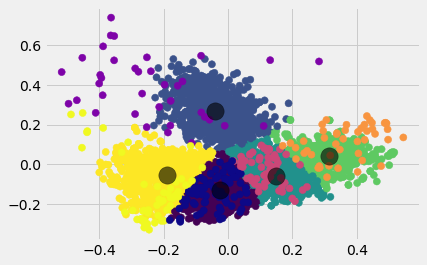

In [ ]:
plt.scatter(Y_sklearn_human[:, 0], Y_sklearn_human[:, 1], c=prediction_human, s=50, cmap='viridis')
plt.scatter(Y_sklearn_bim[:, 0], Y_sklearn_bim[:, 1], c=prediction_bim, s=50, cmap='plasma')
plt.scatter(centroids[:, 0], centroids[:, 1],c='black', s=300, alpha=0.6);

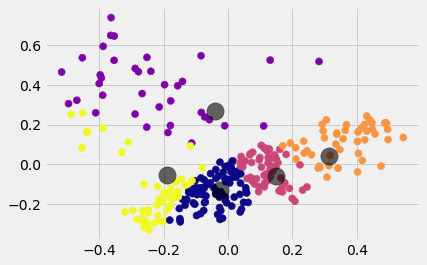

In [ ]:
plt.scatter(Y_sklearn_bim[:, 0], Y_sklearn_bim[:, 1], c=prediction_bim, s=50, cmap='plasma')
plt.scatter(centroids[:, 0], centroids[:, 1],c='black', s=300, alpha=0.6);

In [ ]:
# dominant features per cluster
dfs_bim = get_top_features_cluster(tf_idf_bim, prediction_bim, 15)

In [ ]:
bim_clustered = pd.DataFrame(tf_idf_bim)
bim_clustered['kmean'] = kmeans.labels_[-280:]
bim_clustered['kmean'].value_counts()

0    67
4    66
1    66
2    53
3    28
Name: kmean, dtype: int64

## Mean Distances per Cluster





In [ ]:
# source: https://stackoverflow.com/questions/40828929/sklearn-mean-distance-from-centroid-of-each-cluster
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
        distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
        return np.mean(distances)

###Human Recipe Distances




In [ ]:
c_mean_distances = []
for i, (cx, cy) in enumerate(centroids):
    mean_distance = k_mean_distance(Y_sklearn_human, cx, cy, i, prediction_human)
    c_mean_distances.append(mean_distance)

In [ ]:
c_mean_distances

[0.07342012438977974,
 0.10482402422599724,
 0.07712119367814207,
 0.08366498276594063,
 0.08690176635486772]

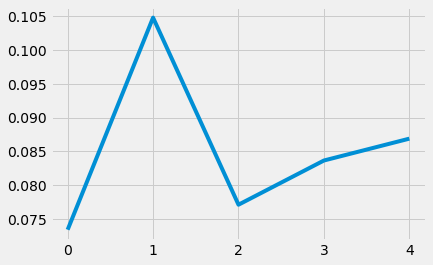

In [ ]:
plt.plot(c_mean_distances)

###BIM Recipe Distances




In [ ]:
c_mean_distances = []
for i, (cx, cy) in enumerate(centroids):
    mean_distance = k_mean_distance(Y_sklearn_bim, cx, cy, i, prediction_bim)
    c_mean_distances.append(mean_distance)

In [ ]:
c_mean_distances

[0.09066672510638807,
 0.2967418696167922,
 0.09278439413615155,
 0.13675401870156773,
 0.18157779418002576]

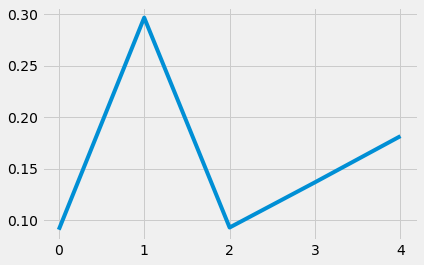

In [ ]:
plt.plot(c_mean_distances)

## Classification and Confusion matrix


### K-means accuracy in classifying human written recipes

In [ ]:
# these are the correct labels for each recipe
labels = pd.read_csv('labels.csv')

In [ ]:
# let's add to dataframe
human_clustered["labels"] = labels

In [ ]:
# lets combine 2 pie classifications 
# and the 2 cake/cupcake classifications 
conditions = [
    (human_clustered['kmean'].eq(0) | human_clustered['kmean'].eq(4)),
    human_clustered['kmean'].eq(1),
    (human_clustered['kmean'].eq(2) | human_clustered['kmean'].eq(3)),
]
choices = [0,1, 2]

human_clustered['combined_kmean'] = np.select(conditions, choices, default=0)

In [ ]:
# lets assign our labels to the correct numerical values
conditions = [
    (human_clustered['labels'].eq('cake') | human_clustered['labels'].eq('cupcakes')),
    human_clustered['labels'].eq('pastry'),
    human_clustered['labels'].eq('cookies'),

]
choices = [0,2,1]

human_clustered['correct_labels'] = np.select(conditions, choices, default=0)

In [ ]:
# looks good so far
human_clustered

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7415,7416,7417,7418,7419,7420,7421,7422,7423,7424,7425,7426,7427,7428,7429,7430,7431,7432,7433,7434,7435,7436,7437,7438,7439,7440,7441,7442,7443,7444,7445,7446,7447,7448,7449,7450,kmean,labels,combined_kmean,correct_labels
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,pastry,0,2
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,cookies,2,1
2,0.0,0.0,0.0,0.0,0.044785,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.119715,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,pastry,2,2
3,0.0,0.0,0.0,0.0,0.024372,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.051236,0.185077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,cake,2,0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.40017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,cupcakes,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4447,0.0,0.0,0.0,0.0,0.077882,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,pastry,0,2
4448,0.0,0.0,0.0,0.0,0.036624,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,pastry,1,2
4449,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,cupcakes,0,0
4450,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.123839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,cupcakes,0,0


In [ ]:
human_clustered["combined_kmean"].value_counts()

0    2223
2    1333
1     896
Name: combined_kmean, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix
human_true = human_clustered.correct_labels
human_pred = human_clustered.combined_kmean
confusion_matrix(human_true, human_pred)

array([[1103,  476,  674],
       [ 516,  193,  321],
       [ 604,  227,  338]])